In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
def get_next_available_dir(root_dir):
    """
    If a directory at 'root_dir' exists, append a number to create a new path.
    For example, if 'RUN' exists, this returns 'RUN_01', and so on.
    """
    if not os.path.exists(root_dir):
        return root_dir

    i = 1
    new_dir = f"{root_dir}_{str(i).zfill(2)}"

    while os.path.exists(new_dir):
        i += 1
        new_dir = f"{root_dir}_{str(i).zfill(2)}"

    return new_dir

In [3]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3
epochs_optimal_lr = 3
patience_teacher = 3
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_teacher = [0,4,8,12]
lmda_list_student = [0,4,8,12]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# SPECIFY OUT DIR NAME
# Create directory and file path to save all outputs
directory_name = 'New_Directory'
# This will append version to end of directory name and create new directory if already exists
output_dir = get_next_available_dir(directory_name)

os.makedirs(output_dir, exist_ok=True)



In [4]:
print(output_dir)

New_Directory_13


In [5]:
output_dir = 'New_Directory_11'

In [6]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Count the number of GPUs available
num_gpus = torch.cuda.device_count()

print("CUDA Available:", cuda_available)
print("Number of GPUs:", num_gpus)

torch.cuda.empty_cache()

CUDA Available: True
Number of GPUs: 1


In [10]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [11]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [12]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [13]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [14]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [15]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [16]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [12]:
len(train_dataset)

10324

In [13]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [14]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu().numpy()
    true_labels = label.cpu().numpy()
    gender = gender.cpu().numpy()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.full(num_classes, np.nan)  # Initialize recalls with NaN
    female_recall = np.full(num_classes, np.nan)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    # Initialize recall difference array
    recall_difference = np.full(num_classes, np.nan)
    
    # Check for at least one instance of each gender per class and compute recall difference
    for i in range(num_classes):
        if male_conf_matrix[i].sum() > 0 and female_conf_matrix[i].sum() > 0:
            recall_difference[i] = male_recall[i] - female_recall[i]

    return recall_difference, male_conf_matrix, female_conf_matrix


In [15]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [16]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()


In [17]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)

In [18]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)

In [19]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        adversary_output = adv(student_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)

In [20]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()

In [21]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [22]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [23]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [24]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [25]:
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            adversary_output = adv(teacher_outputs_detached)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        valid_batches_per_class = np.zeros(num_classes)
        cumulative_recall_diff = np.zeros(num_classes)
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                adversary_output_val = adv(teacher_outputs_detached_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff, male_conf_matrix, female_conf_matrix = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                for i in range(num_classes):
                    # Check if both male and female instances are present for class i
                    if male_conf_matrix[i].sum() > 0 and female_conf_matrix[i].sum() > 0:
                        valid_batches_per_class[i] += 1
                        cumulative_recall_diff[i] += recall_diff[i]

            # Calculate average disparity for each class considering valid batches
            average_disparity_per_class = np.divide(cumulative_recall_diff, valid_batches_per_class, out=np.zeros_like(cumulative_recall_diff), where=valid_batches_per_class!=0)
            valid_disparities = average_disparity_per_class[~np.isnan(average_disparity_per_class)]
            mean_non_zero_abs_disparity = np.mean(np.abs(valid_disparities)) if valid_disparities.size > 0 else np.nan
            
            val_losses.append(total_val_loss)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)

            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: average_disparity_per_class[int(class_label)] for class_label, class_name in class_idx.items()}

            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            # Save the teacher model and its state to the 'output_dir'
            teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
            torch.save(teacher_model.state_dict(), teacher_model_weights_path)
            
            teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_checkpoint{i}.pth')
            torch.save(teacher_model, teacher_model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

        print(f"Data has been appended to {file_path}")
        
    plot_loss_curve(val_losses)
    print(f"Finished Training Teacher for lambda val of {lmda}")
    return val_disparities



def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizers, optimizera, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        student.train()
        student.to(device)
        if lmda != 0:
            adv.train()
            adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        valid_batches_per_class = np.zeros(num_classes)
        cumulative_recall_diff = np.zeros(num_classes)
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizers.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # Run the adversarial model on concatenated true labels, and predicted labels
            if lmda != 0:
                optimizera.zero_grad()
                studentached = student_outputs.detach()
                with torch.no_grad():
                    adversary_output = adv(studentached)
                adversary_loss = adv_criterion(adversary_output, targets)
                
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()

            optimizers.step()
            if lmda != 0:
                optimizera.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        student.eval()
        adv.eval()
        adv.to(device)
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)
                if lmda != 0:
                    val_studentached = val_student_outputs.detach()   

                    val_adversary_output = adv(val_studentached)
                    val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                    
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                    
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                
                # Compute recall differences for gender
                recall_diff, male_conf_matrix, female_conf_matrix = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                for i in range(num_classes):
                    # Check if both male and female instances are present for class i
                    if male_conf_matrix[i].sum() > 0 and female_conf_matrix[i].sum() > 0:
                        valid_batches_per_class[i] += 1
                        cumulative_recall_diff[i] += recall_diff[i]

            # Calculate average disparity for each class considering valid batches
            average_disparity_per_class = np.divide(cumulative_recall_diff, valid_batches_per_class, out=np.zeros_like(cumulative_recall_diff), where=valid_batches_per_class!=0)
            valid_disparities = average_disparity_per_class[~np.isnan(average_disparity_per_class)]
            mean_non_zero_abs_disparity = np.mean(np.abs(valid_disparities)) if valid_disparities.size > 0 else np.nan
            
            val_losses.append(total_val_loss)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')

            class_recall_mapping = {class_name: average_disparity_per_class[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            state_dict_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student.state_dict(), state_dict_path)
            model_path = os.path.join(output_dir, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, model_path)
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        # Writing epoch data to file
        file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
        with open(file_path, 'a') as file:
            file.write(f'*****Epoch {epoch + 1}/{epochs}*****\n')
            file.write(f'*****Train Loss: {epoch_loss:.6f} Val Loss: {total_val_loss:.6f}*****\n')
            file.write(f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
            file.write(f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
    
            # Writing disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        print(f"Data has been appended to {file_path}")

    plot_loss_curve(val_losses)
    print(f'Finished Training Student for lambda value of {lmda}')
    return val_disparities


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.02it/s]


*****Epoch 1/100*****
*****Train Loss:  1.564606 Val Loss:  64.075267*****
*****Validation Accuracy: 64.70%*****
*****Total Avg Disparity: 0.17362850056087104*****

Class Team_Sports: Recall Difference = 0.0921370573729708
Class Celebration: Recall Difference = -0.19517087536331057
Class Parade: Recall Difference = 0.14413122925716632
Class Waiter_Or_Waitress: Recall Difference = -0.22757763975155276
Class Individual_Sports: Recall Difference = -0.15177950051996802
Class Surgeons: Recall Difference = -0.15168067226890758
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.21867315690845102
Class Business: Recall Difference = 0.06560488244698773
Class Dresses: Recall Difference = -0.7644839067702552
Class Water_Activities: Recall Difference = 0.045925716795282
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = 0.14624060150375942
Class Cheering: Recall Difference = 0.13236297807324088
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 2/100*****
*****Train Loss:  0.845368 Val Loss:  63.537973*****
*****Validation Accuracy: 65.05%*****
*****Total Avg Disparity: 0.1606581600186736*****

Class Team_Sports: Recall Difference = 0.12964137166404097
Class Celebration: Recall Difference = -0.1173753462201003
Class Parade: Recall Difference = 0.09106095853172314
Class Waiter_Or_Waitress: Recall Difference = -0.2835610766045548
Class Individual_Sports: Recall Difference = -0.09919019327519082
Class Surgeons: Recall Difference = -0.044747899159663845
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2251645413410119
Class Business: Recall Difference = -0.09332786122259809
Class Dresses: Recall Difference = -0.7869466025403873
Class Water_Activities: Recall Difference = 0.33380011293054773
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = 0.009551656920077986
Class Cheering: Recall Difference = 0.06969486118109397
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.00it/s]


*****Epoch 3/100*****
*****Train Loss:  0.434929 Val Loss:  74.144846*****
*****Validation Accuracy: 64.53%*****
*****Total Avg Disparity: 0.13733264753598642*****

Class Team_Sports: Recall Difference = 0.06530672573761064
Class Celebration: Recall Difference = -0.023738220189804253
Class Parade: Recall Difference = 0.0748983548518781
Class Waiter_Or_Waitress: Recall Difference = -0.2480607315389924
Class Individual_Sports: Recall Difference = -0.09489075533782036
Class Surgeons: Recall Difference = -0.0035714285714285865
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.14536884683943505
Class Business: Recall Difference = -0.09814470130259603
Class Dresses: Recall Difference = -0.7152176593908003
Class Water_Activities: Recall Difference = 0.08550599159294814
Class Picnic: Recall Difference = -0.18181818181818177
Class Rescue: Recall Difference = 0.19817135431170516
Class Cheering: Recall Difference = 0.03833399704175673
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  3.03it/s]


*****Epoch 4/100*****
*****Train Loss:  0.235448 Val Loss:  82.638065*****
*****Validation Accuracy: 63.55%*****
*****Total Avg Disparity: 0.1335086665734441*****

Class Team_Sports: Recall Difference = -0.0002467400390752106
Class Celebration: Recall Difference = -0.09015110542875664
Class Parade: Recall Difference = 0.13296002182059158
Class Waiter_Or_Waitress: Recall Difference = -0.17155279503105592
Class Individual_Sports: Recall Difference = -0.1949641895274635
Class Surgeons: Recall Difference = -0.03844537815126048
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.19328808446455506
Class Business: Recall Difference = -0.04209928473086365
Class Dresses: Recall Difference = -0.6997718584289062
Class Water_Activities: Recall Difference = 0.08853911788694398
Class Picnic: Recall Difference = -0.10909090909090902
Class Rescue: Recall Difference = 0.003907917943005675
Class Cheering: Recall Difference = 0.028411226515106358
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 5/100*****
*****Train Loss:  0.156671 Val Loss:  89.239628*****
*****Validation Accuracy: 63.84%*****
*****Total Avg Disparity: 0.12201894735040263*****

Class Team_Sports: Recall Difference = 0.11380967486422011
Class Celebration: Recall Difference = -0.057631197983654694
Class Parade: Recall Difference = 0.02679821444589059
Class Waiter_Or_Waitress: Recall Difference = -0.03124913733609384
Class Individual_Sports: Recall Difference = -0.08341863782768176
Class Surgeons: Recall Difference = 0.04054621848739495
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.28748114630467575
Class Business: Recall Difference = -0.03152005888847992
Class Dresses: Recall Difference = -0.6839376001973116
Class Water_Activities: Recall Difference = 0.04823295062425496
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.11591014573470715
Class Cheering: Recall Difference = -0.1364584021874385
Class Performance_And_Entertainmen

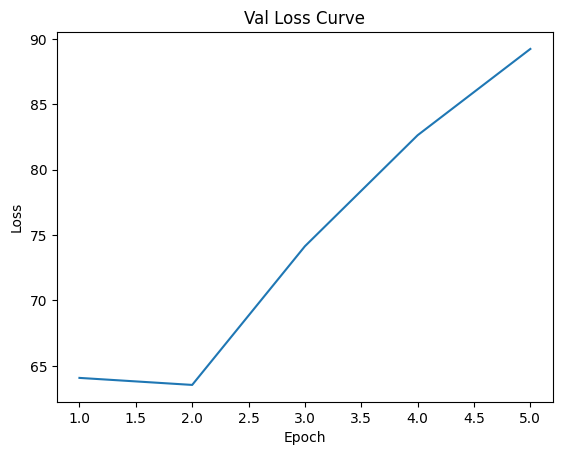

Finished Training Teacher for lambda val of 0
Teacher weights and architecture saved and exported for lambda: 0


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 1/100*****
*****Train Loss:  3.639429 Val Loss:  141.355954*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.12574842030188063*****

Class Team_Sports: Recall Difference = 0.13974320177195734
Class Celebration: Recall Difference = -0.03338159785034623
Class Parade: Recall Difference = 0.014152163844817545
Class Waiter_Or_Waitress: Recall Difference = -0.1321325051759834
Class Individual_Sports: Recall Difference = -0.10096691943954439
Class Surgeons: Recall Difference = 0.043697478991596594
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.18940993646876
Class Business: Recall Difference = 0.10796488112277584
Class Dresses: Recall Difference = -0.6036934270563571
Class Water_Activities: Recall Difference = 0.08971798732668299
Class Picnic: Recall Difference = -0.09090909090909088
Class Rescue: Recall Difference = 0.14067576348278102
Class Cheering: Recall Difference = 0.08090678373219047
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 2/100*****
*****Train Loss:  0.570678 Val Loss:  113.726053*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.11450729886451155*****

Class Team_Sports: Recall Difference = 0.052276865752359826
Class Celebration: Recall Difference = -0.0316993166518495
Class Parade: Recall Difference = 0.09550135188815849
Class Waiter_Or_Waitress: Recall Difference = -0.03457556935817805
Class Individual_Sports: Recall Difference = -0.03082867716649072
Class Surgeons: Recall Difference = -0.09285714285714286
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15618058412176059
Class Business: Recall Difference = -0.03632429948219422
Class Dresses: Recall Difference = -0.7826180786780123
Class Water_Activities: Recall Difference = 0.07007560072777465
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = 0.06157987561496334
Class Cheering: Recall Difference = 0.052463590852201605
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 3/100*****
*****Train Loss: -0.879769 Val Loss:  101.298976*****
*****Validation Accuracy: 64.88%*****
*****Total Avg Disparity: 0.16952706212405483*****

Class Team_Sports: Recall Difference = 0.12962500572451144
Class Celebration: Recall Difference = 0.01701336864689096
Class Parade: Recall Difference = 0.1467830846481521
Class Waiter_Or_Waitress: Recall Difference = -0.21975155279503103
Class Individual_Sports: Recall Difference = -0.03171014712615629
Class Surgeons: Recall Difference = -0.07500000000000001
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.18213126742538507
Class Business: Recall Difference = 0.05250889461415774
Class Dresses: Recall Difference = -0.8111296090763349
Class Water_Activities: Recall Difference = 0.30494447581404105
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.2470342522974102
Class Cheering: Recall Difference = -0.06921336103751624
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 4/100*****
*****Train Loss: -1.624732 Val Loss:  124.530403*****
*****Validation Accuracy: 63.29%*****
*****Total Avg Disparity: 0.18532107813980253*****

Class Team_Sports: Recall Difference = 0.10342516215163844
Class Celebration: Recall Difference = -0.12724722334182317
Class Parade: Recall Difference = 0.17002418753992968
Class Waiter_Or_Waitress: Recall Difference = -0.2277984817115252
Class Individual_Sports: Recall Difference = -0.06453346342882174
Class Surgeons: Recall Difference = -0.28214285714285714
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15854358060240412
Class Business: Recall Difference = -0.01514421251263357
Class Dresses: Recall Difference = -0.7639906276976198
Class Water_Activities: Recall Difference = 0.129257481648786
Class Picnic: Recall Difference = -0.309090909090909
Class Rescue: Recall Difference = 0.1305625174046226
Class Cheering: Recall Difference = -0.0769483860597753
Class Performance_And_Entertainment: R

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 5/100*****
*****Train Loss: -1.804288 Val Loss:  127.424623*****
*****Validation Accuracy: 64.33%*****
*****Total Avg Disparity: 0.1560393439170728*****

Class Team_Sports: Recall Difference = 0.10673395043746897
Class Celebration: Recall Difference = -0.09564971293315476
Class Parade: Recall Difference = 0.07724494163174822
Class Waiter_Or_Waitress: Recall Difference = -0.2674810213940649
Class Individual_Sports: Recall Difference = -0.050947773777747576
Class Surgeons: Recall Difference = -0.3401260504201681
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.13725604460898574
Class Business: Recall Difference = -0.05202637518426993
Class Dresses: Recall Difference = -0.7277222838821062
Class Water_Activities: Recall Difference = 0.09872074785118266
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = -0.051034994894644005
Class Cheering: Recall Difference = -0.027470936795091973
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 6/100*****
*****Train Loss: -1.969692 Val Loss:  121.062391*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.16327443979450929*****

Class Team_Sports: Recall Difference = 0.08777072047075572
Class Celebration: Recall Difference = 0.006483561041562709
Class Parade: Recall Difference = 0.19374679143944512
Class Waiter_Or_Waitress: Recall Difference = -0.1688060731538992
Class Individual_Sports: Recall Difference = -0.00905670344273722
Class Surgeons: Recall Difference = -0.21596638655462186
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.034270304858540136
Class Business: Recall Difference = 0.058299945668366736
Class Dresses: Recall Difference = -0.7304908126772721
Class Water_Activities: Recall Difference = 0.32658353723571115
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.08937157709087534
Class Cheering: Recall Difference = -0.017807870407995564
Class Performance_And_Entertain

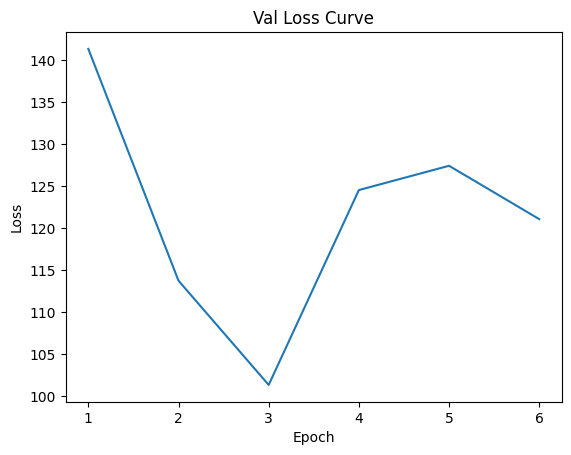

Finished Training Teacher for lambda val of 4
Teacher weights and architecture saved and exported for lambda: 4


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 1/100*****
*****Train Loss:  1.152400 Val Loss: -35.079866*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.15648973510639919*****

Class Team_Sports: Recall Difference = 0.08815440273513504
Class Celebration: Recall Difference = -0.12377538586408547
Class Parade: Recall Difference = 0.11318130861309272
Class Waiter_Or_Waitress: Recall Difference = -0.11394064872325739
Class Individual_Sports: Recall Difference = -0.16098472158745483
Class Surgeons: Recall Difference = -0.13172268907563026
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2090623428858723
Class Business: Recall Difference = 0.07015103804577491
Class Dresses: Recall Difference = -0.6656307806141325
Class Water_Activities: Recall Difference = 0.28250266641570987
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.08848510164299637
Class Cheering: Recall Difference = 0.06286017695279271
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 2/100*****
*****Train Loss: -2.400317 Val Loss: -97.905544*****
*****Validation Accuracy: 66.15%*****
*****Total Avg Disparity: 0.1454991742498022*****

Class Team_Sports: Recall Difference = 0.10851543194724017
Class Celebration: Recall Difference = 0.00234018896133983
Class Parade: Recall Difference = 0.0794307113842346
Class Waiter_Or_Waitress: Recall Difference = -0.1624430641821946
Class Individual_Sports: Recall Difference = -0.045984668080222314
Class Surgeons: Recall Difference = 0.07415966386554618
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.18541409570821332
Class Business: Recall Difference = 0.05389822652980547
Class Dresses: Recall Difference = -0.7428227894931557
Class Water_Activities: Recall Difference = 0.34159514398644836
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.19035087719298247
Class Cheering: Recall Difference = 0.11623353145255524
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 3/100*****
*****Train Loss: -3.890504 Val Loss: -74.557647*****
*****Validation Accuracy: 64.21%*****
*****Total Avg Disparity: 0.1505900733602073*****

Class Team_Sports: Recall Difference = 0.06867696514580775
Class Celebration: Recall Difference = -0.1343429271627538
Class Parade: Recall Difference = -0.03341236341536191
Class Waiter_Or_Waitress: Recall Difference = -0.2502277432712215
Class Individual_Sports: Recall Difference = -0.2897521046935299
Class Surgeons: Recall Difference = -0.000420168067226917
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.18142168289227115
Class Business: Recall Difference = 0.025709378340957302
Class Dresses: Recall Difference = -0.6326180786780121
Class Water_Activities: Recall Difference = 0.27522272413576765
Class Picnic: Recall Difference = -0.1272727272727272
Class Rescue: Recall Difference = 0.05885547201336677
Class Cheering: Recall Difference = 0.08571028088862884
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 4/100*****
*****Train Loss: -4.375846 Val Loss: -61.404831*****
*****Validation Accuracy: 63.84%*****
*****Total Avg Disparity: 0.12146052903373461*****

Class Team_Sports: Recall Difference = 0.03263076906108287
Class Celebration: Recall Difference = -0.013247346857879618
Class Parade: Recall Difference = 0.17084813454078823
Class Waiter_Or_Waitress: Recall Difference = -0.10727398205659076
Class Individual_Sports: Recall Difference = -0.0824160923304651
Class Surgeons: Recall Difference = -0.1130252100840336
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2173511129393482
Class Business: Recall Difference = 0.014364212785265406
Class Dresses: Recall Difference = -0.5480577136514984
Class Water_Activities: Recall Difference = 0.24446954012171407
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.12050496611900123
Class Cheering: Recall Difference = 0.08677449445284238
Class Performance_And_Entertainment: Recall Differen

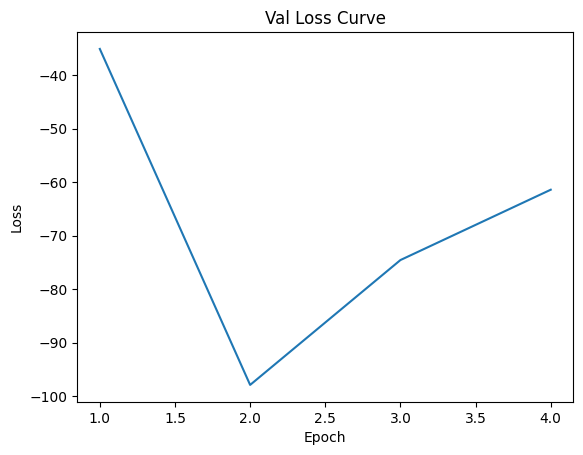

Finished Training Teacher for lambda val of 8
Teacher weights and architecture saved and exported for lambda: 8


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 1/100*****
*****Train Loss: -0.791374 Val Loss: -133.853941*****
*****Validation Accuracy: 63.84%*****
*****Total Avg Disparity: 0.16813860513901505*****

Class Team_Sports: Recall Difference = 0.07098415835186013
Class Celebration: Recall Difference = -0.0755092574248143
Class Parade: Recall Difference = 0.07863799602030486
Class Waiter_Or_Waitress: Recall Difference = -0.18223602484472046
Class Individual_Sports: Recall Difference = -0.06763757278764392
Class Surgeons: Recall Difference = 0.07100840336134451
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2319530143059555
Class Business: Recall Difference = 0.11939662676504781
Class Dresses: Recall Difference = -0.8280429152793193
Class Water_Activities: Recall Difference = 0.2617077608381956
Class Picnic: Recall Difference = 0.1454545454545455
Class Rescue: Recall Difference = 0.051341316253596954
Class Cheering: Recall Difference = 0.06862911250896231
Class Performance_And_Entertainment: R

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 2/100*****
*****Train Loss: -4.074828 Val Loss: -139.789504*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.12406618949382117*****

Class Team_Sports: Recall Difference = 0.0605434410164449
Class Celebration: Recall Difference = 0.05943127297715116
Class Parade: Recall Difference = 0.166782696563806
Class Waiter_Or_Waitress: Recall Difference = -0.073567977915804
Class Individual_Sports: Recall Difference = -0.062391811208266555
Class Surgeons: Recall Difference = -0.09285714285714286
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15069930069930068
Class Business: Recall Difference = 0.06879183194972668
Class Dresses: Recall Difference = -0.5606424959921076
Class Water_Activities: Recall Difference = 0.28424179685049256
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = -0.002696556205328123
Class Cheering: Recall Difference = 0.19722750479946974
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 3/100*****
*****Train Loss: -5.374171 Val Loss: -138.550924*****
*****Validation Accuracy: 64.79%*****
*****Total Avg Disparity: 0.1668403888454113*****

Class Team_Sports: Recall Difference = 0.11477738627064692
Class Celebration: Recall Difference = 0.04566899724262325
Class Parade: Recall Difference = 0.13579113556774725
Class Waiter_Or_Waitress: Recall Difference = -0.24102139406487233
Class Individual_Sports: Recall Difference = -0.09903589165321611
Class Surgeons: Recall Difference = 0.08886554621848741
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.06488527812057225
Class Business: Recall Difference = -0.027409530041108975
Class Dresses: Recall Difference = -0.732297447280799
Class Water_Activities: Recall Difference = 0.30698914611958084
Class Picnic: Recall Difference = 0.1636363636363637
Class Rescue: Recall Difference = 0.1652139608279959
Class Cheering: Recall Difference = 0.028607431367130964
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 4/100*****
*****Train Loss: -6.077085 Val Loss: -114.508813*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.15353943474678586*****

Class Team_Sports: Recall Difference = 0.08588490082809075
Class Celebration: Recall Difference = 0.05700252272868966
Class Parade: Recall Difference = 0.10201254317895996
Class Waiter_Or_Waitress: Recall Difference = -0.13498964803312627
Class Individual_Sports: Recall Difference = -0.13490447898947652
Class Surgeons: Recall Difference = 0.10042016806722687
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.24854540883952647
Class Business: Recall Difference = -0.032532379900800934
Class Dresses: Recall Difference = -0.7697928227894931
Class Water_Activities: Recall Difference = 0.30855041094171526
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = -0.018374640304464857
Class Cheering: Recall Difference = 0.11414352717231316
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 5/100*****
*****Train Loss: -6.256226 Val Loss: -108.912350*****
*****Validation Accuracy: 65.40%*****
*****Total Avg Disparity: 0.15691624759680772*****

Class Team_Sports: Recall Difference = 0.12842826042388
Class Celebration: Recall Difference = 0.004927207421310079
Class Parade: Recall Difference = 0.12756192416612205
Class Waiter_Or_Waitress: Recall Difference = -0.11403726708074535
Class Individual_Sports: Recall Difference = -0.10449503996367697
Class Surgeons: Recall Difference = -0.0035714285714286143
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.22728986699574935
Class Business: Recall Difference = 0.061094383199646364
Class Dresses: Recall Difference = -0.7337711185102972
Class Water_Activities: Recall Difference = 0.31699667482276184
Class Picnic: Recall Difference = -0.3454545454545454
Class Rescue: Recall Difference = 0.10974658869395709
Class Cheering: Recall Difference = 0.0059743284805863104
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 6/100*****
*****Train Loss: -6.469379 Val Loss: -94.135051*****
*****Validation Accuracy: 64.70%*****
*****Total Avg Disparity: 0.15975247006364574*****

Class Team_Sports: Recall Difference = 0.0675005607947531
Class Celebration: Recall Difference = 0.02694544118265015
Class Parade: Recall Difference = 0.08242556011371602
Class Waiter_Or_Waitress: Recall Difference = -0.26044168391994477
Class Individual_Sports: Recall Difference = -0.035782431717956704
Class Surgeons: Recall Difference = 0.00042016806722688926
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2514271676036382
Class Business: Recall Difference = 0.03235865499023396
Class Dresses: Recall Difference = -0.5837649525218892
Class Water_Activities: Recall Difference = 0.34281322542192105
Class Picnic: Recall Difference = 0.34545454545454546
Class Rescue: Recall Difference = -0.014415668801633705
Class Cheering: Recall Difference = 0.14774554954154456
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 7/100*****
*****Train Loss: -6.603169 Val Loss: -84.130177*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.18947487999763282*****

Class Team_Sports: Recall Difference = 0.10834253930525994
Class Celebration: Recall Difference = -0.19260532802376581
Class Parade: Recall Difference = 0.09673008550669719
Class Waiter_Or_Waitress: Recall Difference = -0.21605244996549344
Class Individual_Sports: Recall Difference = -0.12047660989661471
Class Surgeons: Recall Difference = -0.04873949579831935
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2686160244983774
Class Business: Recall Difference = 0.053629820471925736
Class Dresses: Recall Difference = -0.7320508077444815
Class Water_Activities: Recall Difference = 0.26726331639375117
Class Picnic: Recall Difference = -0.23636363636363633
Class Rescue: Recall Difference = -0.12800055694792536
Class Cheering: Recall Difference = 0.09640886335191715
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 8/100*****
*****Train Loss: -6.518099 Val Loss: -73.210951*****
*****Validation Accuracy: 63.69%*****
*****Total Avg Disparity: 0.15927322399186689*****

Class Team_Sports: Recall Difference = 0.059527528695992656
Class Celebration: Recall Difference = -0.04058516299762559
Class Parade: Recall Difference = 0.15011316136803393
Class Waiter_Or_Waitress: Recall Difference = -0.20350586611456176
Class Individual_Sports: Recall Difference = -0.10351844883946347
Class Surgeons: Recall Difference = -0.27899159663865547
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.19579848256318844
Class Business: Recall Difference = 0.045726982569087825
Class Dresses: Recall Difference = -0.46898507830805275
Class Water_Activities: Recall Difference = 0.23680437919568353
Class Picnic: Recall Difference = -0.3818181818181818
Class Rescue: Recall Difference = 0.004455583402951824
Class Cheering: Recall Difference = -0.054660393493309645
Class Performance_And_Enterta

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 9/100*****
*****Train Loss: -6.591857 Val Loss: -93.266437*****
*****Validation Accuracy: 63.87%*****
*****Total Avg Disparity: 0.14426416992582544*****

Class Team_Sports: Recall Difference = 0.1174860234423145
Class Celebration: Recall Difference = -0.12731985100772697
Class Parade: Recall Difference = 0.04233952437700563
Class Waiter_Or_Waitress: Recall Difference = -0.277791580400276
Class Individual_Sports: Recall Difference = -0.03794126626626879
Class Surgeons: Recall Difference = 0.01743697478991596
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2267253987842223
Class Business: Recall Difference = 0.018540640645903772
Class Dresses: Recall Difference = -0.6429152793192748
Class Water_Activities: Recall Difference = 0.2812196499153021
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = 0.016016894087069505
Class Cheering: Recall Difference = 0.13418123664681864
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 10/100*****
*****Train Loss: -6.673509 Val Loss: -74.737033*****
*****Validation Accuracy: 62.51%*****
*****Total Avg Disparity: 0.13758518619957275*****

Class Team_Sports: Recall Difference = 0.08593604550729377
Class Celebration: Recall Difference = -0.017912551431004793
Class Parade: Recall Difference = 0.12792634818122076
Class Waiter_Or_Waitress: Recall Difference = -0.24768806073153896
Class Individual_Sports: Recall Difference = -0.23275443527563802
Class Surgeons: Recall Difference = -0.08256302521008402
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.19458041958041958
Class Business: Recall Difference = 0.05257547520705415
Class Dresses: Recall Difference = -0.4948760636330003
Class Water_Activities: Recall Difference = 0.22982150699542006
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = -0.02315046876450383
Class Cheering: Recall Difference = 0.04496909466559027
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 11/100*****
*****Train Loss: -6.725783 Val Loss: -91.219069*****
*****Validation Accuracy: 63.95%*****
*****Total Avg Disparity: 0.17496566753564186*****

Class Team_Sports: Recall Difference = 0.07017453625352849
Class Celebration: Recall Difference = -0.0764840420475921
Class Parade: Recall Difference = 0.1367520635286752
Class Waiter_Or_Waitress: Recall Difference = -0.274824016563147
Class Individual_Sports: Recall Difference = -0.16503615714780293
Class Surgeons: Recall Difference = -0.14453781512605043
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.20735408382467202
Class Business: Recall Difference = 0.05000991211517528
Class Dresses: Recall Difference = -0.6626156122826489
Class Water_Activities: Recall Difference = 0.29255317146621496
Class Picnic: Recall Difference = 0.10909090909090913
Class Rescue: Recall Difference = 0.060461338531513954
Class Cheering: Recall Difference = 0.06533743478048858
Class Performance_And_Entertainment: 

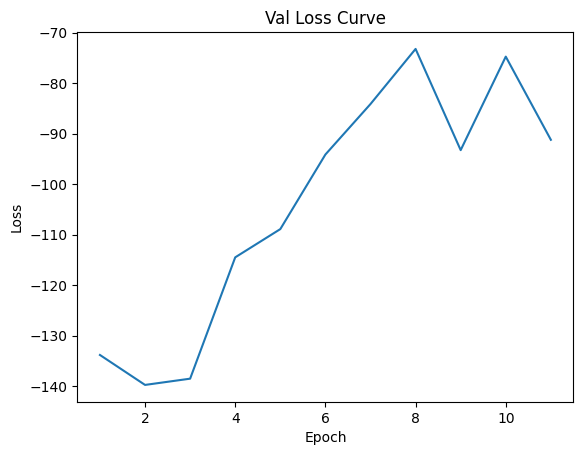

Finished Training Teacher for lambda val of 12
Teacher weights and architecture saved and exported for lambda: 12


In [26]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state to the 'output_dir'
    teacher_model_weights_path = os.path.join(output_dir, f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model.state_dict(), teacher_model_weights_path)
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, teacher_model_path)
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 1/100*****
*****Train Loss:  0.689429 Val Loss:  16.362494*****
*****Validation Accuracy: 61.93%*****
*****Total Avg Disparity: 0.13623525831432023*****

Class Team_Sports: Recall Difference = 0.057484882920619484
Class Celebration: Recall Difference = -0.06085990457829105
Class Parade: Recall Difference = 0.17128939376465613
Class Waiter_Or_Waitress: Recall Difference = -0.14626639061421673
Class Individual_Sports: Recall Difference = -0.10187630261927327
Class Surgeons: Recall Difference = -0.018277310924369766
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.058067096302390396
Class Business: Recall Difference = 0.03417074153916259
Class Dresses: Recall Difference = -0.7377605130102355
Class Water_Activities: Recall Difference = 0.07119831858962292
Class Picnic: Recall Difference = -0.036363636363636376
Class Rescue: Recall Difference = 0.06776199758655899
Class Cheering: Recall Difference = 0.20748119041298016
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 2/100*****
*****Train Loss:  0.418138 Val Loss:  16.178214*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.1254160123566873*****

Class Team_Sports: Recall Difference = 0.09536822304082408
Class Celebration: Recall Difference = -0.18715120427655682
Class Parade: Recall Difference = 0.1051334222998391
Class Waiter_Or_Waitress: Recall Difference = -0.07162180814354728
Class Individual_Sports: Recall Difference = -0.11168516547425743
Class Surgeons: Recall Difference = -0.015126050420168097
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1884295443118972
Class Business: Recall Difference = 0.06365570102412209
Class Dresses: Recall Difference = -0.5593414724380318
Class Water_Activities: Recall Difference = 0.04780726519856956
Class Picnic: Recall Difference = 0.10909090909090907
Class Rescue: Recall Difference = 0.045112781954887195
Class Cheering: Recall Difference = 0.029895608146546813
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 3/100*****
*****Train Loss:  0.284389 Val Loss:  17.367820*****
*****Validation Accuracy: 64.76%*****
*****Total Avg Disparity: 0.1483810973045988*****

Class Team_Sports: Recall Difference = 0.06985978011107356
Class Celebration: Recall Difference = -0.21396369541764418
Class Parade: Recall Difference = 0.0026745564946464516
Class Waiter_Or_Waitress: Recall Difference = -0.20938578329882682
Class Individual_Sports: Recall Difference = -0.0503405844719521
Class Surgeons: Recall Difference = -0.11911764705882355
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15512591983180218
Class Business: Recall Difference = 0.04423492686650584
Class Dresses: Recall Difference = -0.7620298433838943
Class Water_Activities: Recall Difference = 0.026175105088148555
Class Picnic: Recall Difference = -0.19999999999999996
Class Rescue: Recall Difference = 0.024909495962127538
Class Cheering: Recall Difference = -0.03828290052320092
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 4/100*****
*****Train Loss:  0.190902 Val Loss:  18.555406*****
*****Validation Accuracy: 63.78%*****
*****Total Avg Disparity: 0.16124092773012022*****

Class Team_Sports: Recall Difference = 0.14960685418672062
Class Celebration: Recall Difference = -0.13300618169524
Class Parade: Recall Difference = 0.0946093656468469
Class Waiter_Or_Waitress: Recall Difference = -0.18557625948930298
Class Individual_Sports: Recall Difference = -0.015503527119366787
Class Surgeons: Recall Difference = -0.000420168067226917
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16389003153709034
Class Business: Recall Difference = 0.0018619392303602877
Class Dresses: Recall Difference = -0.6655567887532371
Class Water_Activities: Recall Difference = 0.25341018884497146
Class Picnic: Recall Difference = -0.21818181818181814
Class Rescue: Recall Difference = 0.2033927411120393
Class Cheering: Recall Difference = 0.02743913748607113
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 5/100*****
*****Train Loss:  0.136671 Val Loss:  17.935044*****
*****Validation Accuracy: 64.82%*****
*****Total Avg Disparity: 0.16084812422919118*****

Class Team_Sports: Recall Difference = 0.08069930157820493
Class Celebration: Recall Difference = -0.045712934702801064
Class Parade: Recall Difference = 0.04484257688005814
Class Waiter_Or_Waitress: Recall Difference = -0.15832988267770876
Class Individual_Sports: Recall Difference = -0.08672376247334075
Class Surgeons: Recall Difference = -0.01302521008403365
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.11909022350198821
Class Business: Recall Difference = 0.07123126386284283
Class Dresses: Recall Difference = -0.670360093723024
Class Water_Activities: Recall Difference = 0.29895727460944854
Class Picnic: Recall Difference = -0.23636363636363633
Class Rescue: Recall Difference = 0.18796064234660725
Class Cheering: Recall Difference = 0.023172932615986436
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 6/100*****
*****Train Loss:  0.106923 Val Loss:  17.139710*****
*****Validation Accuracy: 65.83%*****
*****Total Avg Disparity: 0.1651492624610849*****

Class Team_Sports: Recall Difference = 0.13740940944998206
Class Celebration: Recall Difference = -0.0011338660378358606
Class Parade: Recall Difference = 0.0629344704936909
Class Waiter_Or_Waitress: Recall Difference = -0.07838509316770187
Class Individual_Sports: Recall Difference = -0.09504676481643035
Class Surgeons: Recall Difference = -0.05945378151260505
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.09187691393573745
Class Business: Recall Difference = -0.03436220699378593
Class Dresses: Recall Difference = -0.6920150450117154
Class Water_Activities: Recall Difference = 0.30964991530208924
Class Picnic: Recall Difference = -0.23636363636363633
Class Rescue: Recall Difference = 0.26626752065348563
Class Cheering: Recall Difference = 0.05179492944824608
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 7/100*****
*****Train Loss:  0.090829 Val Loss:  17.173519*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.18402273968490077*****

Class Team_Sports: Recall Difference = 0.06834042694950074
Class Celebration: Recall Difference = -0.06321315435764373
Class Parade: Recall Difference = 0.10556604664700617
Class Waiter_Or_Waitress: Recall Difference = -0.2881711525189786
Class Individual_Sports: Recall Difference = -0.08734328816885428
Class Surgeons: Recall Difference = -0.02899159663865547
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2131176013528954
Class Business: Recall Difference = -0.03362849626007518
Class Dresses: Recall Difference = -0.7101492169194722
Class Water_Activities: Recall Difference = 0.252977288412071
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.25374083356539495
Class Cheering: Recall Difference = 0.13812306418376505
Class Performance_And_Entertainment: R

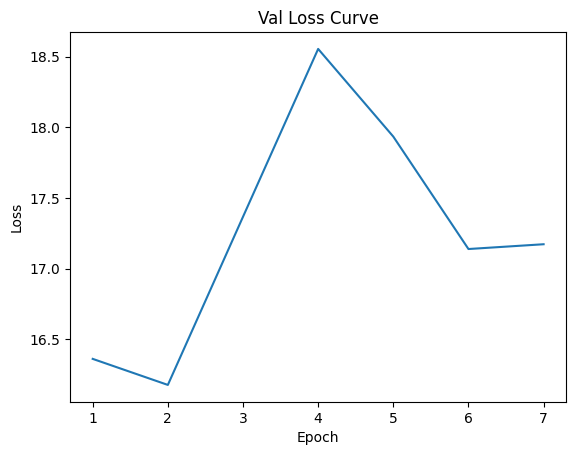

Finished Training Student for lambda value of 0
Student weights and architecture saved and exported for lambda: 0


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 0: loss - 0.6908868260589647


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.96it/s]


*******Epoch 1: loss - 0.41649631493621403


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 0.2769293449359176


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.58it/s]


Average Pretrain Adversary epoch loss:  0.4699463246413219


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.58it/s]


Average Pretrain Adversary epoch loss:  0.4694972446671239


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.46944509980119303


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 1/100*****
*****Train Loss: -0.703351 Val Loss: -35.720736*****
*****Validation Accuracy: 62.94%*****
*****Total Avg Disparity: 0.1382206005365776*****

Class Team_Sports: Recall Difference = 0.0779236996005099
Class Celebration: Recall Difference = -0.05349644855758488
Class Parade: Recall Difference = -0.0073039615723274
Class Waiter_Or_Waitress: Recall Difference = -0.19652173913043477
Class Individual_Sports: Recall Difference = -0.06939575650852946
Class Surgeons: Recall Difference = 0.0615546218487395
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.10331367978426802
Class Business: Recall Difference = -0.0038607007028059527
Class Dresses: Recall Difference = -0.7466642002713035
Class Water_Activities: Recall Difference = 0.293987389422172
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = 0.06732572171168663
Class Cheering: Recall Difference = 0.010828055271109105
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 2/100*****
*****Train Loss: -1.185467 Val Loss: -33.143275*****
*****Validation Accuracy: 63.98%*****
*****Total Avg Disparity: 0.15190054832626684*****

Class Team_Sports: Recall Difference = 0.06184695449271041
Class Celebration: Recall Difference = 0.028574639189924422
Class Parade: Recall Difference = 0.0725245326054921
Class Waiter_Or_Waitress: Recall Difference = -0.19790200138026223
Class Individual_Sports: Recall Difference = -0.10774746082662033
Class Surgeons: Recall Difference = -0.03529411764705881
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.21758878376525434
Class Business: Recall Difference = -0.016009059166953908
Class Dresses: Recall Difference = -0.721186336169688
Class Water_Activities: Recall Difference = 0.12783016500407807
Class Picnic: Recall Difference = -0.16363636363636358
Class Rescue: Recall Difference = 0.15356446672236146
Class Cheering: Recall Difference = -0.026024228517970684
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 3/100*****
*****Train Loss: -1.448318 Val Loss: -30.525545*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.1845280687335089*****

Class Team_Sports: Recall Difference = 0.07250986245679705
Class Celebration: Recall Difference = -0.1488287545629096
Class Parade: Recall Difference = 0.16883296813131893
Class Waiter_Or_Waitress: Recall Difference = -0.12451345755693581
Class Individual_Sports: Recall Difference = -0.05843810907594051
Class Surgeons: Recall Difference = -0.11827731092436974
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2003885003885004
Class Business: Recall Difference = -0.001026088920825785
Class Dresses: Recall Difference = -0.668325317548403
Class Water_Activities: Recall Difference = 0.3255530459878286
Class Picnic: Recall Difference = -0.3454545454545454
Class Rescue: Recall Difference = 0.14914601318110088
Class Cheering: Recall Difference = -0.035964436064561234
Class Performance_And_Entertainment:

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 4/100*****
*****Train Loss: -1.571565 Val Loss: -31.702966*****
*****Validation Accuracy: 66.61%*****
*****Total Avg Disparity: 0.15659645774942324*****

Class Team_Sports: Recall Difference = 0.05723080412460938
Class Celebration: Recall Difference = -0.027992480825861237
Class Parade: Recall Difference = 0.07455700354950727
Class Waiter_Or_Waitress: Recall Difference = -0.25609385783298827
Class Individual_Sports: Recall Difference = -0.0834370835206507
Class Surgeons: Recall Difference = -0.12142857142857141
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15435348964760728
Class Business: Recall Difference = -0.06763984553458238
Class Dresses: Recall Difference = -0.7020717721050684
Class Water_Activities: Recall Difference = 0.3138863793211619
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.1380441845354126
Class Cheering: Recall Difference = 0.004614299620557438
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 5/100*****
*****Train Loss: -1.657885 Val Loss: -38.863723*****
*****Validation Accuracy: 66.49%*****
*****Total Avg Disparity: 0.16488991190590455*****

Class Team_Sports: Recall Difference = 0.06822604096670375
Class Celebration: Recall Difference = -0.021745583614365436
Class Parade: Recall Difference = 0.00870230269480643
Class Waiter_Or_Waitress: Recall Difference = -0.21456176673567975
Class Individual_Sports: Recall Difference = -0.08691945648273045
Class Surgeons: Recall Difference = -0.17731092436974794
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.14529228940993644
Class Business: Recall Difference = -0.016024053918790783
Class Dresses: Recall Difference = -0.7262547786410161
Class Water_Activities: Recall Difference = 0.2875864232385971
Class Picnic: Recall Difference = 0.25454545454545463
Class Rescue: Recall Difference = 0.1488072031931681
Class Cheering: Recall Difference = -0.07011216672355595
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 6/100*****
*****Train Loss: -1.689726 Val Loss: -39.064968*****
*****Validation Accuracy: 66.18%*****
*****Total Avg Disparity: 0.14751743527933134*****

Class Team_Sports: Recall Difference = 0.0681467946538945
Class Celebration: Recall Difference = 0.04716061229508336
Class Parade: Recall Difference = 0.10283199425928058
Class Waiter_Or_Waitress: Recall Difference = -0.1999585921325052
Class Individual_Sports: Recall Difference = -0.09415540246878333
Class Surgeons: Recall Difference = -0.10672268907563026
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.13407833996069288
Class Business: Recall Difference = 0.00046242256768570523
Class Dresses: Recall Difference = -0.7325440868171168
Class Water_Activities: Recall Difference = 0.31062550975594455
Class Picnic: Recall Difference = -0.018181818181818188
Class Rescue: Recall Difference = 0.14129768866610973
Class Cheering: Recall Difference = 0.020838778451419245
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 7/100*****
*****Train Loss: -1.700646 Val Loss: -39.899514*****
*****Validation Accuracy: 66.55%*****
*****Total Avg Disparity: 0.1499484336765307*****

Class Team_Sports: Recall Difference = 0.04428854547665858
Class Celebration: Recall Difference = -0.01694657310106919
Class Parade: Recall Difference = 0.04382896829973291
Class Waiter_Or_Waitress: Recall Difference = -0.14567287784679087
Class Individual_Sports: Recall Difference = -0.1051881843758724
Class Surgeons: Recall Difference = -0.142436974789916
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16665409753645047
Class Business: Recall Difference = 0.024177771546192606
Class Dresses: Recall Difference = -0.7697928227894931
Class Water_Activities: Recall Difference = 0.3461189535102579
Class Picnic: Recall Difference = -0.18181818181818177
Class Rescue: Recall Difference = 0.17412512763389953
Class Cheering: Recall Difference = 0.010019337844744607
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 8/100*****
*****Train Loss: -1.716187 Val Loss: -38.332342*****
*****Validation Accuracy: 67.13%*****
*****Total Avg Disparity: 0.16371790272132225*****

Class Team_Sports: Recall Difference = 0.06372251066608625
Class Celebration: Recall Difference = 0.009578089924433018
Class Parade: Recall Difference = 0.025029867849957775
Class Waiter_Or_Waitress: Recall Difference = -0.1390062111801242
Class Individual_Sports: Recall Difference = -0.08954376609500637
Class Surgeons: Recall Difference = -0.10672268907563026
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16340097810686047
Class Business: Recall Difference = -0.10907784223573698
Class Dresses: Recall Difference = -0.761542730299667
Class Water_Activities: Recall Difference = 0.315561829474873
Class Picnic: Recall Difference = 0.290909090909091
Class Rescue: Recall Difference = 0.1714703425229741
Class Cheering: Recall Difference = -0.12888838772130384
Class Performance_And_Entertainment: Re

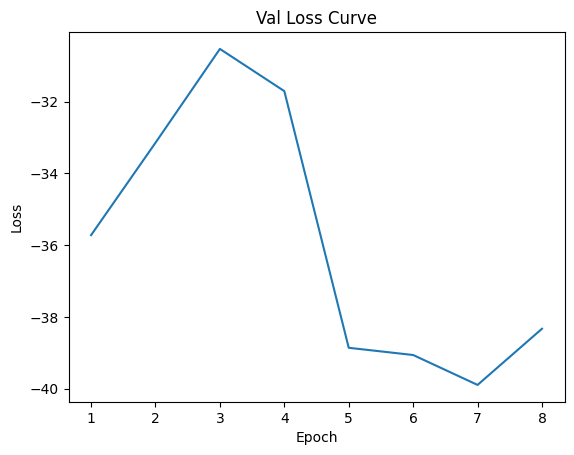

Finished Training Student for lambda value of 4
Student weights and architecture saved and exported for lambda: 4


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:21<00:00,  1.98it/s]


*******Epoch 0: loss - 0.6923456696080573


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 1: loss - 0.42055554540804874


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:21<00:00,  1.98it/s]


*******Epoch 2: loss - 0.27889965998905675


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.60it/s]


Average Pretrain Adversary epoch loss:  0.37912303384071516


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.37931858049130734


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.60it/s]


Average Pretrain Adversary epoch loss:  0.37982435883195315


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 1/100*****
*****Train Loss: -2.019370 Val Loss: -97.746398*****
*****Validation Accuracy: 62.63%*****
*****Total Avg Disparity: 0.12755785653138715*****

Class Team_Sports: Recall Difference = 0.07555566171985252
Class Celebration: Recall Difference = -0.057367117558947224
Class Parade: Recall Difference = 0.07297143735824399
Class Waiter_Or_Waitress: Recall Difference = -0.025065562456866825
Class Individual_Sports: Recall Difference = -0.08445796253634467
Class Surgeons: Recall Difference = -0.15399159663865544
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.19306526806526805
Class Business: Recall Difference = 0.038513611145190085
Class Dresses: Recall Difference = -0.7620360093723023
Class Water_Activities: Recall Difference = 0.0587147876278311
Class Picnic: Recall Difference = 0.054545454545454564
Class Rescue: Recall Difference = 0.2315093288777499
Class Cheering: Recall Difference = -0.04083420473282802
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 2/100*****
*****Train Loss: -2.371568 Val Loss: -103.084959*****
*****Validation Accuracy: 65.25%*****
*****Total Avg Disparity: 0.1831549043524249*****

Class Team_Sports: Recall Difference = 0.0949878764178111
Class Celebration: Recall Difference = -0.12439278462991858
Class Parade: Recall Difference = 0.025223670216173933
Class Waiter_Or_Waitress: Recall Difference = -0.1894824016563147
Class Individual_Sports: Recall Difference = -0.07478793664748158
Class Surgeons: Recall Difference = -0.2781512605042017
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2022293066410713
Class Business: Recall Difference = 0.06398905188378876
Class Dresses: Recall Difference = -0.7937291897891233
Class Water_Activities: Recall Difference = 0.26390802434280697
Class Picnic: Recall Difference = 0.09090909090909094
Class Rescue: Recall Difference = -0.06099508029332589
Class Cheering: Recall Difference = -0.062233180183743395
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 3/100*****
*****Train Loss: -2.644958 Val Loss: -121.542349*****
*****Validation Accuracy: 65.48%*****
*****Total Avg Disparity: 0.16340583175489604*****

Class Team_Sports: Recall Difference = 0.10493034517559847
Class Celebration: Recall Difference = -0.04729851746026919
Class Parade: Recall Difference = 0.1684437341768676
Class Waiter_Or_Waitress: Recall Difference = -0.19075224292615597
Class Individual_Sports: Recall Difference = -0.0897811834065614
Class Surgeons: Recall Difference = -0.11071428571428574
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.23051213492389963
Class Business: Recall Difference = -0.015947658579237543
Class Dresses: Recall Difference = -0.7332840054260698
Class Water_Activities: Recall Difference = 0.29916933308237653
Class Picnic: Recall Difference = -0.054545454545454564
Class Rescue: Recall Difference = -0.00992295553699063
Class Cheering: Recall Difference = -0.04433418306071623
Class Performance_And_Entertai

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 4/100*****
*****Train Loss: -2.755764 Val Loss: -117.943177*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.17061594331351326*****

Class Team_Sports: Recall Difference = 0.07730631397224784
Class Celebration: Recall Difference = -0.08544010004326183
Class Parade: Recall Difference = 0.08074765730687769
Class Waiter_Or_Waitress: Recall Difference = -0.1153071083505866
Class Individual_Sports: Recall Difference = -0.167776155117669
Class Surgeons: Recall Difference = -0.30231092436974794
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2420094611271082
Class Business: Recall Difference = 0.11054843791685895
Class Dresses: Recall Difference = -0.7093414724380319
Class Water_Activities: Recall Difference = 0.24685049250266644
Class Picnic: Recall Difference = 0.07272727272727275
Class Rescue: Recall Difference = 0.13415483152325255
Class Cheering: Recall Difference = 0.03426186141768118
Class Performance_And_Entertainment: R

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.83it/s]


*****Epoch 5/100*****
*****Train Loss: -2.784391 Val Loss: -113.656077*****
*****Validation Accuracy: 66.09%*****
*****Total Avg Disparity: 0.16272633314310825*****

Class Team_Sports: Recall Difference = 0.08139739452975883
Class Celebration: Recall Difference = -0.02900448430448488
Class Parade: Recall Difference = 0.07989313401907108
Class Waiter_Or_Waitress: Recall Difference = -0.14234644582470668
Class Individual_Sports: Recall Difference = -0.290873040551404
Class Surgeons: Recall Difference = -0.1285714285714286
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.17458521870286572
Class Business: Recall Difference = -0.06582608424713689
Class Dresses: Recall Difference = -0.7461030953261808
Class Water_Activities: Recall Difference = 0.25644206035510386
Class Picnic: Recall Difference = -0.0727272727272727
Class Rescue: Recall Difference = 0.042374454655156435
Class Cheering: Recall Difference = -0.00945530307545327
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 6/100*****
*****Train Loss: -2.853744 Val Loss: -108.125814*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.1579271193844615*****

Class Team_Sports: Recall Difference = 0.08313160178020722
Class Celebration: Recall Difference = -0.02972516716176708
Class Parade: Recall Difference = 0.06506113609861737
Class Waiter_Or_Waitress: Recall Difference = -0.10922015182884746
Class Individual_Sports: Recall Difference = -0.11294765432313143
Class Surgeons: Recall Difference = -0.22857142857142856
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.16069632981397686
Class Business: Recall Difference = 0.035958933853670695
Class Dresses: Recall Difference = -0.7390800345295351
Class Water_Activities: Recall Difference = 0.3128994918125353
Class Picnic: Recall Difference = 0.018181818181818188
Class Rescue: Recall Difference = -0.09766545994616171
Class Cheering: Recall Difference = -0.06018421746519368
Class Performance_And_Entertainm

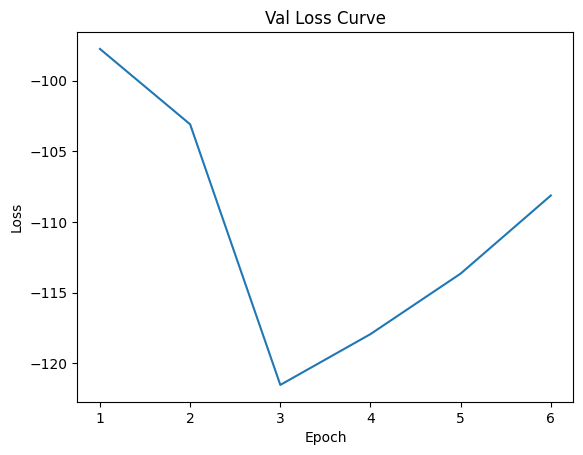

Finished Training Student for lambda value of 8
Student weights and architecture saved and exported for lambda: 8


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:21<00:00,  1.98it/s]


*******Epoch 0: loss - 0.6878121182506467


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 1: loss - 0.4139986433732657


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 2: loss - 0.27634345878053596


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.4624414563546946


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:41<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.46242491496197974


100%|█████████████████████████████████████████████████████████████████████████| 162/162 [01:42<00:00,  1.59it/s]


Average Pretrain Adversary epoch loss:  0.46226587063736385


100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 1/100*****
*****Train Loss: -4.294579 Val Loss: -241.500548*****
*****Validation Accuracy: 62.16%*****
*****Total Avg Disparity: 0.16744899102132993*****

Class Team_Sports: Recall Difference = 0.09162365308665472
Class Celebration: Recall Difference = -0.16000256045514233
Class Parade: Recall Difference = 0.10899465285672183
Class Waiter_Or_Waitress: Recall Difference = -0.1915527950310559
Class Individual_Sports: Recall Difference = -0.10757382593101153
Class Surgeons: Recall Difference = -0.14558823529411763
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.15734151469445587
Class Business: Recall Difference = -0.02747465010622905
Class Dresses: Recall Difference = -0.6996238747071155
Class Water_Activities: Recall Difference = 0.31671466214944477
Class Picnic: Recall Difference = 0.14545454545454545
Class Rescue: Recall Difference = 0.052594449085677154
Class Cheering: Recall Difference = 0.07398769114351092
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 2/100*****
*****Train Loss: -4.888749 Val Loss: -249.179339*****
*****Validation Accuracy: 64.39%*****
*****Total Avg Disparity: 0.12859793737889505*****

Class Team_Sports: Recall Difference = 0.055970397072232565
Class Celebration: Recall Difference = -0.06057972849088471
Class Parade: Recall Difference = 0.0821581626769033
Class Waiter_Or_Waitress: Recall Difference = -0.07171842650103522
Class Individual_Sports: Recall Difference = -0.08962438309778539
Class Surgeons: Recall Difference = -0.15714285714285717
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1111271081859317
Class Business: Recall Difference = 0.006549298654561808
Class Dresses: Recall Difference = -0.5699654704649156
Class Water_Activities: Recall Difference = 0.3200423489553924
Class Picnic: Recall Difference = -0.0727272727272727
Class Rescue: Recall Difference = -0.017956929360438134
Class Cheering: Recall Difference = 0.03574671712656691
Class Performance_And_Entertainme

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 3/100*****
*****Train Loss: -5.051357 Val Loss: -243.896385*****
*****Validation Accuracy: 65.48%*****
*****Total Avg Disparity: 0.13620295778579988*****

Class Team_Sports: Recall Difference = 0.07680504621090818
Class Celebration: Recall Difference = -0.04421723378313702
Class Parade: Recall Difference = 0.0889440609365647
Class Waiter_Or_Waitress: Recall Difference = -0.01018633540372669
Class Individual_Sports: Recall Difference = -0.13464351064340183
Class Surgeons: Recall Difference = -0.050840336134453795
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.13459710224416105
Class Business: Recall Difference = 0.12121759332285649
Class Dresses: Recall Difference = -0.6402269083734122
Class Water_Activities: Recall Difference = 0.11355041094171525
Class Picnic: Recall Difference = -0.10909090909090902
Class Rescue: Recall Difference = 0.05877657105727283
Class Cheering: Recall Difference = 0.1798437440740319
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 4/100*****
*****Train Loss: -5.138185 Val Loss: -247.172355*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.14049717820609828*****

Class Team_Sports: Recall Difference = 0.035962899796214094
Class Celebration: Recall Difference = -0.1010550376012388
Class Parade: Recall Difference = 0.09910418966341006
Class Waiter_Or_Waitress: Recall Difference = -0.12118702553485161
Class Individual_Sports: Recall Difference = -0.0744571537021727
Class Surgeons: Recall Difference = -0.05189075630252099
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.197817541935189
Class Business: Recall Difference = 0.024055496160759315
Class Dresses: Recall Difference = -0.6200394623258108
Class Water_Activities: Recall Difference = 0.12834117573248008
Class Picnic: Recall Difference = -0.05454545454545451
Class Rescue: Recall Difference = 0.17656641604010026
Class Cheering: Recall Difference = 0.05678213387224649
Class Performance_And_Entertainment

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 5/100*****
*****Train Loss: -5.169752 Val Loss: -235.946589*****
*****Validation Accuracy: 65.92%*****
*****Total Avg Disparity: 0.1523910860582427*****

Class Team_Sports: Recall Difference = 0.07452040736979726
Class Celebration: Recall Difference = -0.02837708540707105
Class Parade: Recall Difference = 0.046242977412392715
Class Waiter_Or_Waitress: Recall Difference = -0.17155279503105592
Class Individual_Sports: Recall Difference = -0.1755834758986991
Class Surgeons: Recall Difference = -0.22457983193277312
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.19734220028337676
Class Business: Recall Difference = 0.031236658078763337
Class Dresses: Recall Difference = -0.7421815266987298
Class Water_Activities: Recall Difference = 0.07878976096367402
Class Picnic: Recall Difference = -0.09090909090909088
Class Rescue: Recall Difference = 0.12736470806646247
Class Cheering: Recall Difference = -0.039531259312235535
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 6/100*****
*****Train Loss: -5.249821 Val Loss: -248.931378*****
*****Validation Accuracy: 64.85%*****
*****Total Avg Disparity: 0.14890609838085786*****

Class Team_Sports: Recall Difference = 0.06978827551346047
Class Celebration: Recall Difference = -0.1551627397074759
Class Parade: Recall Difference = 0.056718194016544855
Class Waiter_Or_Waitress: Recall Difference = -0.1326708074534162
Class Individual_Sports: Recall Difference = -0.14612882688466297
Class Surgeons: Recall Difference = -0.11911764705882355
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2398555692673339
Class Business: Recall Difference = -0.03746244009401904
Class Dresses: Recall Difference = -0.5764952521889258
Class Water_Activities: Recall Difference = 0.06524593763724199
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.0962498839691822
Class Cheering: Recall Difference = -0.012686827148654444
Class Performance_And_Entertainmen

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 7/100*****
*****Train Loss: -5.215409 Val Loss: -244.395033*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.16277069841232608*****

Class Team_Sports: Recall Difference = 0.06630511325846941
Class Celebration: Recall Difference = -0.17479013031555674
Class Parade: Recall Difference = 0.15870387882981588
Class Waiter_Or_Waitress: Recall Difference = -0.161656314699793
Class Individual_Sports: Recall Difference = -0.11291927417674663
Class Surgeons: Recall Difference = -0.26029411764705884
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.1162518853695324
Class Business: Recall Difference = 0.08235719446245761
Class Dresses: Recall Difference = -0.660075225058577
Class Water_Activities: Recall Difference = 0.04924869816174164
Class Picnic: Recall Difference = -0.09090909090909088
Class Rescue: Recall Difference = 0.1503945047804697
Class Cheering: Recall Difference = -0.11642908162620302
Class Performance_And_Entertainment: 

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 8/100*****
*****Train Loss: -5.259370 Val Loss: -254.555557*****
*****Validation Accuracy: 66.35%*****
*****Total Avg Disparity: 0.1369460522289175*****

Class Team_Sports: Recall Difference = 0.06045154952740031
Class Celebration: Recall Difference = -0.06435212145630696
Class Parade: Recall Difference = 0.022912333210684043
Class Waiter_Or_Waitress: Recall Difference = -0.16822636300897173
Class Individual_Sports: Recall Difference = -0.10273955824585881
Class Surgeons: Recall Difference = -0.009873949579831925
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.159032634032634
Class Business: Recall Difference = 0.06502655239497344
Class Dresses: Recall Difference = -0.7562338142804292
Class Water_Activities: Recall Difference = 0.09304096869314259
Class Picnic: Recall Difference = -0.10909090909090902
Class Rescue: Recall Difference = 0.13848974287570778
Class Cheering: Recall Difference = -0.006565629475516832
Class Performance_And_Entertainm

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 9/100*****
*****Train Loss: -5.241949 Val Loss: -258.629951*****
*****Validation Accuracy: 66.29%*****
*****Total Avg Disparity: 0.13181820655390608*****

Class Team_Sports: Recall Difference = 0.05355251608583883
Class Celebration: Recall Difference = -0.02222264584376212
Class Parade: Recall Difference = 0.04201928522918026
Class Waiter_Or_Waitress: Recall Difference = -0.15547273982056595
Class Individual_Sports: Recall Difference = -0.08496370964498823
Class Surgeons: Recall Difference = -0.021428571428571436
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.2502982311805841
Class Business: Recall Difference = 0.10421329158171262
Class Dresses: Recall Difference = -0.7131828832161795
Class Water_Activities: Recall Difference = 0.09057500470543947
Class Picnic: Recall Difference = -0.10909090909090902
Class Rescue: Recall Difference = 0.01027568922305766
Class Cheering: Recall Difference = -0.010958295632888877
Class Performance_And_Entertain

100%|███████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 10/100*****
*****Train Loss: -5.271804 Val Loss: -255.192314*****
*****Validation Accuracy: 66.64%*****
*****Total Avg Disparity: 0.15855867033642668*****

Class Team_Sports: Recall Difference = 0.07142122114027147
Class Celebration: Recall Difference = -0.04055454714487033
Class Parade: Recall Difference = 0.01763150292985376
Class Waiter_Or_Waitress: Recall Difference = -0.253567977915804
Class Individual_Sports: Recall Difference = -0.10665329260681368
Class Surgeons: Recall Difference = 0.13928571428571423
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.21115795968737147
Class Business: Recall Difference = 0.08369544685334157
Class Dresses: Recall Difference = -0.7567209273646566
Class Water_Activities: Recall Difference = 0.08905546144676578
Class Picnic: Recall Difference = -0.1272727272727272
Class Rescue: Recall Difference = 0.15639561867632043
Class Cheering: Recall Difference = -0.06997705465164791
Class Performance_And_Entertainment

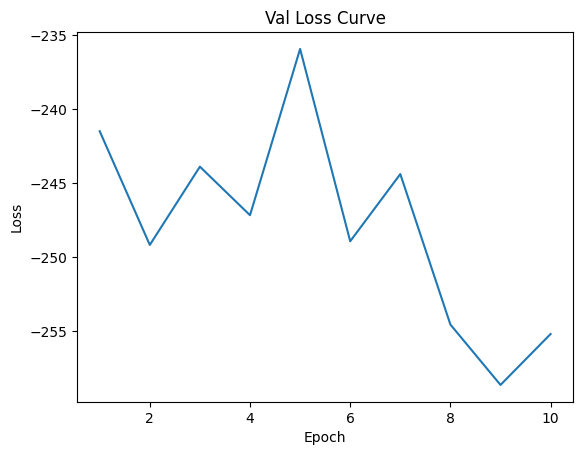

Finished Training Student for lambda value of 12
Student weights and architecture saved and exported for lambda: 12


In [27]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model_path = os.path.join(output_dir, 'teacher_model_ckd_wider_lambda0.pth')
    teacher_model = torch.load(teacher_model_path)
    teacher_model_weights_path = os.path.join(output_dir, 'teacher_model_weights_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    
    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, 
                                                                               adv_criterion, student_optimizer, student_optimizer_adv, device, alpha, 
                                                                               temperature, epochs, lmda=i, patience=patience_student)

    # Save the student model's state dictionary to the 'output_dir'
    student_model_weights_path = os.path.join(output_dir, f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model.state_dict(), student_model_weights_path)
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{i}.pth')
    torch.save(student_model, student_model_path)

    print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


In [17]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [18]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


NameError: name 'lambda_results' is not defined

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting only with markers and no lines
plt.scatter(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.scatter(student_lambdas, student_acc, label='Student Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# Extracting lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.scatter(student_lambdas, student_prec, label='Student Precision', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# Extracting lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.scatter(student_lambdas, student_rec, label='Student Recall', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# Extracting lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.scatter(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# Extracting lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.scatter(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Extracting lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.scatter(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            # Take the last value if there are multiple
            teacher_disparity = teacher_disparity[-1] if isinstance(teacher_disparity, list) else teacher_disparity
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            # Take the last value if there are multiple
            student_disparity = student_disparity[-1] if isinstance(student_disparity, list) else student_disparity
            student_disparities.append((key, student_disparity))

# Extracting lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Creating a scatter plot
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.scatter(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.scatter(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (num_images + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda0.pth')
teacher_model = torch.load(teacher_model_path)
student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda4.pth')
student_model = torch.load(student_model_path)

# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

for i in range(num_classes):
    # Display images with details
    print('#'*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('#'*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=10, cols=5)
